In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import umap

import matplotlib.pyplot as plt
import matplotlib
 
import pickle as pk
import h5py
import scanpy as sc

# Load data

Our algorithm requires at least two inputs:

- `count`$\in \mathbb{R}^{n_{\text{cell}}\ \ \times\ \ n_{\text{gene}}}$, the raw count matrix for the UMI/non-UMI model, or the preprocessed expression matrix for the Gaussian model.
- `NUM_CLUSTER`$\in \mathbb{N}^+$, the number of clusters.

One can also provides some prior information:

- `grouping`$\in \mathbb{R}^{n_{\text{cell}}}$, the true/estimated groupings
- `gene_names`$\in \mathbb{R}^{n_{\text{cell}}}$
- `cell_ids`$\in \mathbb{R}^{n_{\text{cell}}}$

We have prepare some datasets in **hdf5** format, which can be easily loaded by the following codes:

In [2]:
from scTrajVAE import get_igraph, louvain_igraph, plot_clusters, load_data

file_name = 'dentate'
data = load_data(path='data/',
                 file_name=file_name)

# To see the available fields of the dataset
print(data.keys())

dict_keys(['count', 'grouping', 'gene_names', 'cell_ids', 'milestone_network', 'root_milestone_id', 'type'])


Or we can directly use `scanpy` to load dataset and deal with `AnnData` object. 

In [3]:
adata = sc.AnnData(data['count'])

# Preprocess data

We follows the precedure

- Remove cells without expressions.
- Remove genes without variations across samples.
- Apply log-normalization to the count data $X$ and get $X_{\text{norm}}$.
- Select influential genes based on $X$ by the method described in Page 12-13: Data preprocessing - Feature selection for individual datasets, https://www.biorxiv.org/content/biorxiv/early/2018/11/02/460147.full.pdf.
- Apply per-gene standardization to $X_{\text{norm}}$ as the input of the neural network.


Removing 0 cells without expression.
Removing 277 genes without variability.
min normailized value: 0.0
max normailized value: 8.149757


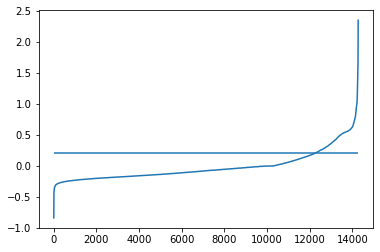

Number of cells in each class: 
0 <---> Granule-immature    1333
1 <---> Granule-mature      1712
2 <---> Neuroblast_1          97
3 <---> Neuroblast_2         777
4 <---> nIPC                  88
dtype: int64


In [3]:
from scTrajVAE import scTrajVAE

# clear the tf session if necessary
tf.keras.backend.clear_session() 

# create an instance
model = scTrajVAE()

# fit in data
model.get_data(X = data['count'],             # count or expression matrix, (dense or sparse) numpy array 
               labels = data['grouping'],     # (optional) labels, which will be converted to string
               covariate=None,                # (optional) covariates
               gene_names=data['gene_names'], # (optional) gene names, which will be converted to string
               cell_names=None                # (optional) cell names, which will be converted to string
              )

# preprocess data
model.preprocess_data(K = 1e4,                # (optional) denominator of the scale factor for log-normalization (the default is 1e4)
                      gene_num = 2000,        # (optional) maximum number of influential genes to keep (the default is 2000)
                      data_type = 'UMI',      # (optional) data_type can be 'UMI', 'non-UMI' or 'Gaussian' (the default is 'UMI')
                      npc = 64                # (optional) number of PCs to keep if data_type='Gaussian' (the default is 64)
                     )

Or we can use `scanpy` to preprocess the data. Input `adata` to `get_data` function. This step uses Seurat processing as above.

In [5]:
# create an instance
model = scTGMVAE()

# fit in data
model.get_data(adata = adata,                 # AnnData scanpy object 
               labels = data['grouping'],     # (optional) labels, which will be converted to string
               covariate=None,                # (optional) covariates
               gene_names=data['gene_names'], # (optional) gene names, which will be converted to string
               cell_names=None                # (optional) cell names, which will be converted to string
              )

# preprocess data
model.preprocess_data(processed = False,      # (optional) User can specify whether the AnnData has been processed, if so, Gaussian is applied
                      dimred = False,         # (optional) If the AnnData has been processed, user can specify whether the AnnData has been through dimension reduction, if not, PCA is applied
                      K = 1e4,                # (optional) denominator of the scale factor for log-normalization (the default is 1e4)
                      gene_num = 2000,        # (optional) maximum number of influential genes to keep (the default is 2000)
                      data_type = 'UMI',      # (optional) data_type can be 'UMI', 'non-UMI' or 'Gaussian' (the default is 'UMI')
                      npc = 64                # (optional) number of PCs to keep if data_type='Gaussian' (the default is 64)
                     )

/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Number of cells in each class: 
0 <---> Granule-immature    1333
1 <---> Granule-mature      1712
2 <---> Neuroblast_1          97
3 <---> Neuroblast_2         777
4 <---> nIPC                  88
dtype: int64


# Build model

Now we are able to create the neural network.

In [4]:
model.build_model(dim_latent = 8,         # The size of the latent dimension
                  dimensions=[16]         # The size of each layer in the encoder between the input layer and the 
                                          # latent layer. The size of each layer in the decoder is the reverse.
                  )

# Pretrain

In the current stage, we only define the Autoencoder. The latent sturcture is still undefined. Before adding that, we'd better pretrain the Autoencoder to learn a better reprsentation $Z$ of $X$.

A large batch size will give a better and stable model, while it takes more memory to run. So if you are concerned about this, you could reduce the batch size.

In [5]:
model.pre_train(learning_rate = 1e-3,        # (Optional) the initial learning rate for the Adam optimizer (the default is 1e-3).
                batch_size=256,              # (Optional) the batch size for pre-training (the default is 32). 
                L=1,                         # (Optional) the number of MC samples (the default is 1).
                num_epoch = 300,             # (Optional) the maximum number of epoches (the default is 300).                
                num_step_per_epoch = None,   # (Optional) the number of step per epoch, it will be inferred from number of cells and batch size if it is None (the default is None).
                early_stopping_tolerance=1,  # (Optional) the minimum change of loss to be considered as an improvement (the default is 1e-3).
                early_stopping_patience=5,   # (Optional) the maximum number of epoches if there is no improvement (the default is 10).
                early_stopping_warmup=0,     # (Optional) the number of warmup epoches (the default is 0).
                path_to_weights=None         # (Optional) the path of weight file to be saved; not saving weight if None (the default is None).
                ) 

Pretrain - Start of epoch 0
16/16 [==============================] - 3s 191ms/step - Reconstructed Loss: 1156.4729
 Training loss over epoch: 1194.3974609375
Pretrain - Start of epoch 1
16/16 [==============================] - 1s 67ms/step - Reconstructed Loss: 1141.7123
 Training loss over epoch: 1174.0765380859375
Pretrain - Start of epoch 2
16/16 [==============================] - 1s 67ms/step - Reconstructed Loss: 1149.6719
 Training loss over epoch: 1146.24169921875
Pretrain - Start of epoch 3
16/16 [==============================] - 1s 68ms/step - Reconstructed Loss: 1108.5669
 Training loss over epoch: 1114.725830078125
Pretrain - Start of epoch 4
16/16 [==============================] - 1s 69ms/step - Reconstructed Loss: 1085.8990
 Training loss over epoch: 1089.6796875
Pretrain - Start of epoch 5
16/16 [==============================] - 1s 70ms/step - Reconstructed Loss: 1056.3822
 Training loss over epoch: 1072.485107421875
Pretrain - Start of epoch 6
16/16 [=================

16/16 [==============================] - 1s 67ms/step - Reconstructed Loss: 776.9599
 Training loss over epoch: 768.6171875
Pretrain - Start of epoch 104
16/16 [==============================] - 1s 66ms/step - Reconstructed Loss: 763.7906
 Training loss over epoch: 770.699462890625
Pretrain - Start of epoch 105
16/16 [==============================] - 1s 68ms/step - Reconstructed Loss: 745.4129
 Training loss over epoch: 766.4813232421875
Pretrain - Start of epoch 106
16/16 [==============================] - 1s 67ms/step - Reconstructed Loss: 784.3267
 Training loss over epoch: 766.3182373046875
Pretrain - Start of epoch 107
16/16 [==============================] - 1s 66ms/step - Reconstructed Loss: 770.3748
 Training loss over epoch: 764.3843994140625
Pretrain - Start of epoch 108
16/16 [==============================] - 1s 68ms/step - Reconstructed Loss: 786.7478
 Training loss over epoch: 763.5159912109375
Pretrain - Start of epoch 109
16/16 [==============================] - 1s 67m

You can also save and load model weights by the following codes:

In [12]:
# save model weight
# model.save_model(path_to_file='weight/dentate_pretrain.checkpoint')

# load model weight
model.load_model(path_to_file='weight/dentate_pretrain.checkpoint', # path to the weight file.
                 n_clusters=None                      # (Optional) parameter to initialize or re-initialize the GMM layer
                                                      # set to None if we don't know the number of clusters yet.
                )

# Clustering and initialize latent structure

If you have information of the grouping/labels of cells, you are free to use them to initialze the latent structure, so that you will get better estimate and inference results, especially when the sample size is small or the classes are unbalanced.

In [13]:
# Get latent representations of X after pre-training
z = model.get_latent_z()

# Assign pre-given labels to initialize the latent structure
# The object 'model.labels' is encoded as categorical data from 'model.label_names'.
labels = model.label_names    

We can plot the clusters to see how it looks like.

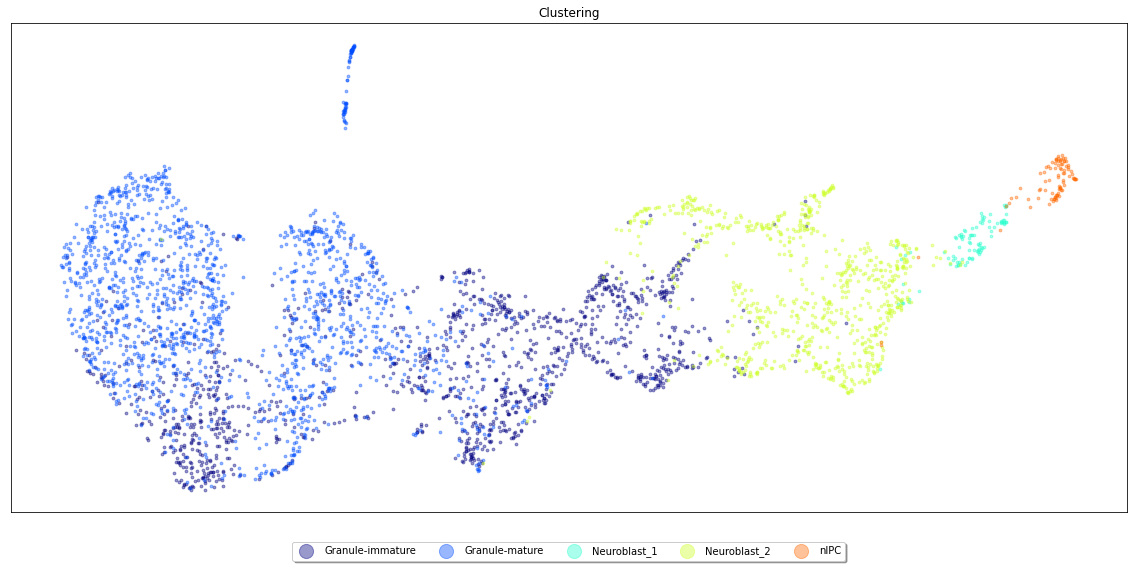

In [7]:
# Dimension reducation via UMAP
embed_z = umap.UMAP().fit_transform(z)        
plot_clusters(embed_z, labels)

Suppose we want to select a subset of the cells. For example, we want to remove cluster '09' (which is encoded as 4), we can do:

```
cell_subsets = model.cell_names[labels != 'nIPC']
model.set_cell_subset(cell_subsets) 
# this will update the model variables 'selected_cell_subset' & 'selected_cell_subset_id',
# corresponding to cell names & cell ids respectively.
# However, if you do not select a subset, these two variables will also be initialzed to
# be include all cells.
labels = labels[model.selected_cell_subset_id]
z = z[model.selected_cell_subset_id,:]
```

Then the later operations, such as training and inference, will automatically only deal with the selected subset of cells. 

Now we need to determine $k$, either from prior information or clustering results. And we also need to initialze $\pi$ and $\mu$. 

- $\mu$: The user can provide $\mu$, the clustering centers. If not given, $\mu$ is initialized by the mean of each cluster corrsponding to the given clustering labels in latent space. If clustering labels are not given, $\mu$ is sampled from uniform $[-1,1]$.
- $\pi$: The user can provide $\pi=(\pi_{1,1},\cdots,\pi_{1,k},\pi_{2,2},\cdots,\pi_{2,k},\cdots, \pi_{k,k})\in\mathbb{R}^{1\times K}$, the prior proportion for each node and each edge. If not given, $\pi$ is uniformly initialized. 

In [14]:
NUM_CLUSTER = len(np.unique(labels))

model.init_latent_space(
    NUM_CLUSTER,                     # numebr of clusters
    cluster_labels=labels,           # (optional) clustering labels or their names for plotting
    mu=None,                         # (optional) initial mean
    log_pi=None                      # (optional) initial pi
               )                   

In case we don't have labels, we could do Louvain clustering by the following codes. You can choose different resolution parameter to get satisfactory clustering results.

```
from scTGMVAE import get_igraph, louvain_igraph, plot_clusters
z = model.get_latent_z()
embed_z = umap.UMAP().fit_transform(z)
g = get_igraph(z)
labels = louvain_igraph(g, res = 0.6) 
plot_clusters(embed_z, labels)
print(np.unique(labels))
```

And we can also use estimated cluster labels from other algorithms and softwares.

# Train

Warmup:0
Start of epoch 0
16/16 [==============================] - 3s 213ms/step - loss_neg_E_nb: 752.9772 - loss_neg_E_pz: 21.4029 - loss_E_qzx   : -4.3827 - loss_total: 771.0884
 Training loss over epoch: 770.3986206054688
 734.962036,  22.088989, -4.370695


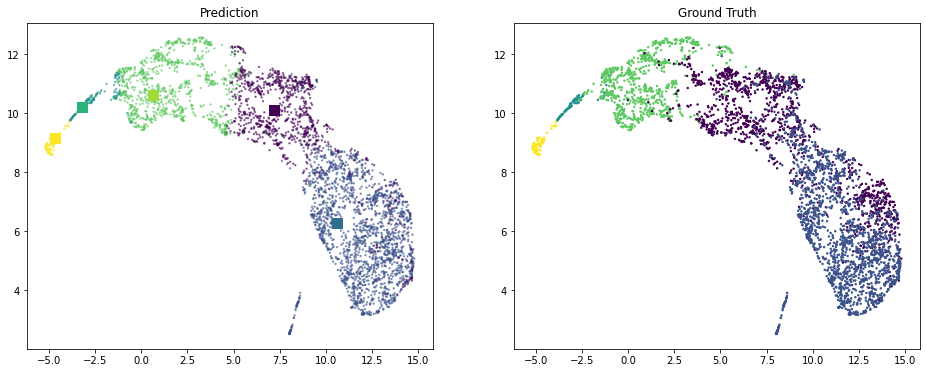

Start of epoch 1
16/16 [==============================] - 1s 83ms/step - loss_neg_E_nb: 741.9066 - loss_neg_E_pz: 20.3430 - loss_E_qzx   : -4.4398 - loss_total: 764.7820
 Training loss over epoch: 761.8272705078125
 729.650330,  20.514381, -4.425909
Start of epoch 2
16/16 [==============================] - 1s 79ms/step - loss_neg_E_nb: 725.8360 - loss_neg_E_pz: 19.5425 - loss_E_qzx   : -4.5012 - loss_total: 756.8914
 Training loss over epoch: 757.9100341796875
 727.666321,  19.608566, -4.486751
Start of epoch 3
16/16 [==============================] - 1s 83ms/step - loss_neg_E_nb: 730.2422 - loss_neg_E_pz: 19.1546 - loss_E_qzx   : -4.5636 - loss_total: 755.2357
 Training loss over epoch: 755.777587890625
 727.090271,  18.892595, -4.548951
Start of epoch 4
16/16 [==============================] - 1s 82ms/step - loss_neg_E_nb: 717.4987 - loss_neg_E_pz: 18.1581 - loss_E_qzx   : -4.6255 - loss_total: 751.9437
 Training loss over epoch: 752.0859375
 724.734070,  18.286987, -4.611042
Start o

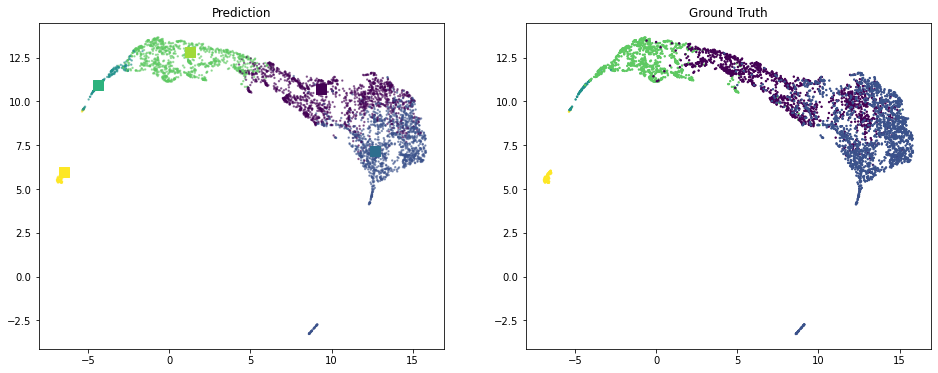

Start of epoch 31
16/16 [==============================] - 1s 80ms/step - loss_neg_E_nb: 725.1107 - loss_neg_E_pz: 13.7814 - loss_E_qzx   : -6.0200 - loss_total: 727.8198
 Training loss over epoch: 727.3654174804688
 712.434753,  13.475150, -6.009815
Start of epoch 32
16/16 [==============================] - 1s 80ms/step - loss_neg_E_nb: 724.0614 - loss_neg_E_pz: 13.9558 - loss_E_qzx   : -6.0627 - loss_total: 727.1204
 Training loss over epoch: 727.10888671875
 712.299377,  13.457379, -6.052649
Start of epoch 33
16/16 [==============================] - 1s 81ms/step - loss_neg_E_nb: 718.1068 - loss_neg_E_pz: 13.8702 - loss_E_qzx   : -6.1058 - loss_total: 728.2437
 Training loss over epoch: 726.0951538085938
 711.607117,  13.339794, -6.095805
Start of epoch 34
16/16 [==============================] - 1s 83ms/step - loss_neg_E_nb: 691.9414 - loss_neg_E_pz: 13.8137 - loss_E_qzx   : -6.1483 - loss_total: 724.5821
 Training loss over epoch: 724.6846313476562
 710.393372,  13.284082, -6.13850

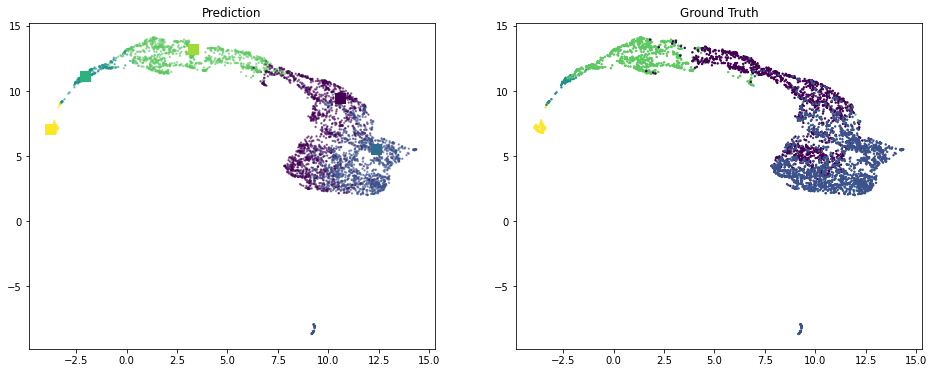

Start of epoch 61
16/16 [==============================] - 1s 80ms/step - loss_neg_E_nb: 701.4085 - loss_neg_E_pz: 12.9279 - loss_E_qzx   : -7.0824 - loss_total: 713.0249
 Training loss over epoch: 714.941162109375
 703.030884,  13.030590, -7.075454
Start of epoch 62
16/16 [==============================] - 1s 77ms/step - loss_neg_E_nb: 699.9109 - loss_neg_E_pz: 12.8503 - loss_E_qzx   : -7.1086 - loss_total: 713.0705
 Training loss over epoch: 714.9270629882812
 702.820007,  13.156153, -7.102678
Start of epoch 63
16/16 [==============================] - 1s 74ms/step - loss_neg_E_nb: 707.3496 - loss_neg_E_pz: 13.1017 - loss_E_qzx   : -7.1358 - loss_total: 713.2494
 Training loss over epoch: 714.9677734375
 703.118164,  13.054047, -7.129227
Start of epoch 64
16/16 [==============================] - 1s 73ms/step - loss_neg_E_nb: 699.0882 - loss_neg_E_pz: 12.9601 - loss_E_qzx   : -7.1635 - loss_total: 714.1357
 Training loss over epoch: 713.8883056640625
 702.037842,  13.082418, -7.157151


In [15]:
model.train(learning_rate = 1e-3,        # (Optional) the initial learning rate for the Adam optimizer (the default is 1e-3).
            batch_size=256,              # (Optional) the batch size for pre-training (the default is 32). 
            L=1,                         # (Optional) the number of MC samples (the default is 1).
            num_epoch = 300,             # (Optional) the maximum number of epoches (the default is 300).                
            num_step_per_epoch = None,   # (Optional) the number of step per epoch, it will be inferred from number of cells and batch size if it is None (the default is None).
            early_stopping_tolerance=1,  # (Optional) the minimum change of loss to be considered as an improvement (the default is 1e-3).
            early_stopping_patience=5,   # (Optional) the maximum number of epoches if there is no improvement (the default is 10).
            early_stopping_warmup=0,     # (Optional) the number of warmup epoches (the default is 0).
            weight=2,
            plot_every_num_epoch=30,
            path_to_weights=None         # (Optional) the path of weight file to be saved; not saving weight if None (the default is None). 
            )

In [6]:
# save model weight
# model.save_model(path_to_file='weight/dentate_train.checkpoint')

# load model weight
NUM_CLUSTER = len(np.unique(model.label_names))
model.load_model(path_to_file='weight/dentate_train.checkpoint', # path to the weight file.
                 n_clusters=NUM_CLUSTER                      # (Optional) parameter to initialize or re-initialize the GMM layer
                                                      # set to None if we don't know the number of clusters yet.
                )
model.cluster_labels = model.label_names

# Inference

## Trajectory and Pseudotime

In [7]:
# initialze inference
model.init_inference(batch_size=32, L=100) # L is the number of MC samples
# after initialization, we can access some variables by model.pc_x, model.w, model.w_tilde, etc..

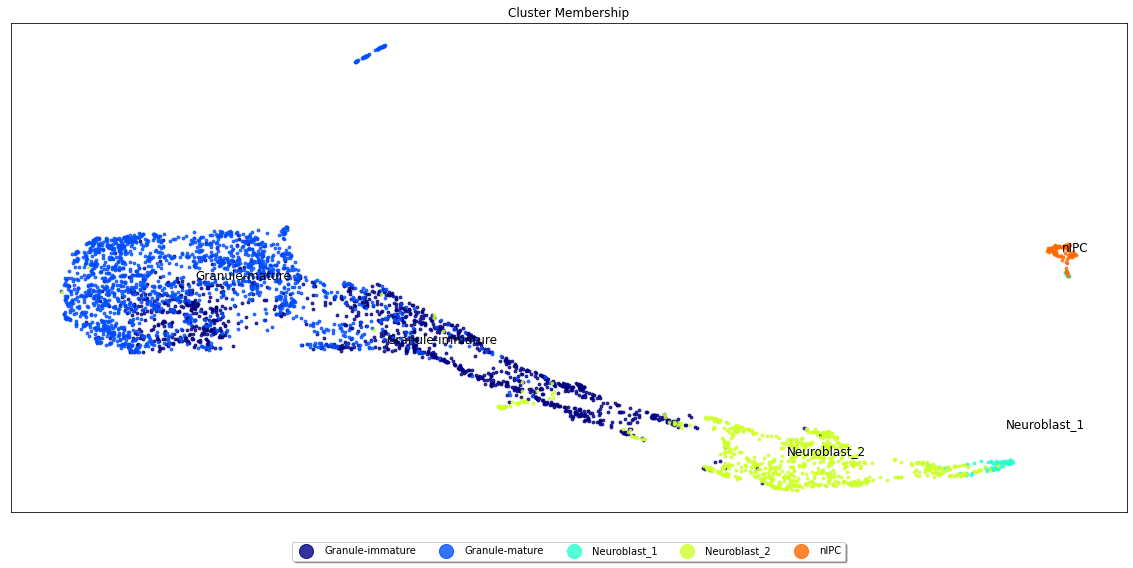

[[0.   0.43 0.   0.25 0.  ]
 [0.43 0.   0.   0.   0.  ]
 [0.   0.   0.   0.2  0.13]
 [0.25 0.   0.2  0.   0.  ]
 [0.   0.   0.13 0.   0.  ]]
[(0, 1), (0, 3), (2, 3), (2, 4)]


In [8]:
import networkx as nx
# compute inference score, and get umap embedding
# a plot of clustering result will be displayed
G = model.comp_inference_score(method='modified_map',  # 'mean', 'modified_mean', 'map', and 'modified_map'
                               thres=0.5,              # (Optional) threshold for compute the conditional probablity, only applies to 'mean' and 'modified_mean'
                               no_loop=True            # if no_loop=True, then find the maximum spanning tree
                               )           
# returned G is the score graph
print(np.round(nx.to_numpy_matrix(G), 2))
print(G.edges)

Now, the user needs to provide the initial node for the trajectory.

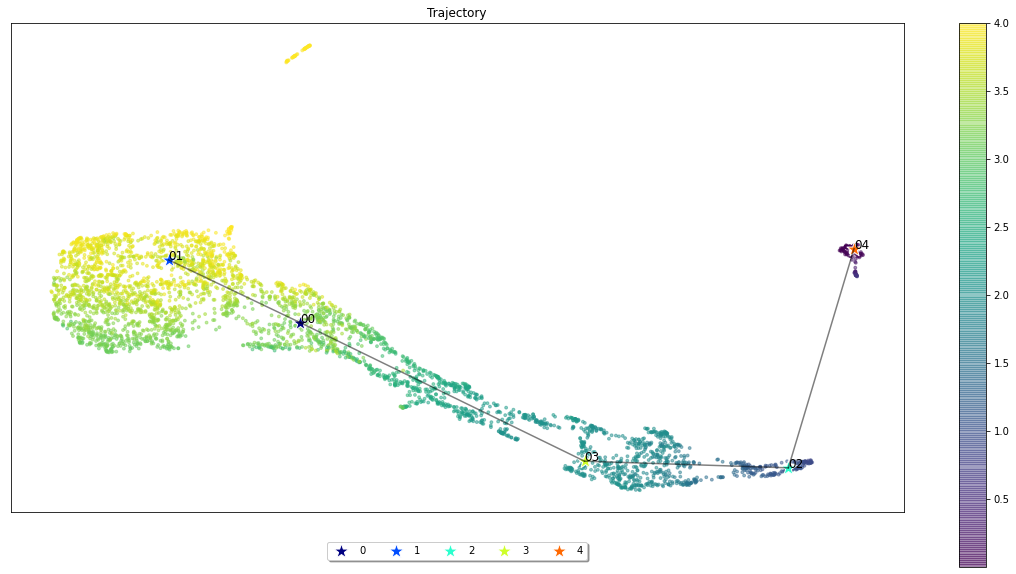

(<networkx.classes.graph.Graph at 0x7f82a7349128>,
 array([[0.0000000e+00, 0.0000000e+00, 2.0606451e-02, 0.0000000e+00,
         9.7939354e-01],
        [0.0000000e+00, 0.0000000e+00, 4.9339263e-03, 0.0000000e+00,
         9.9506605e-01],
        [0.0000000e+00, 0.0000000e+00, 1.2172101e-02, 0.0000000e+00,
         9.8782790e-01],
        ...,
        [3.1356332e-01, 6.8643665e-01, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00],
        [2.5327306e-02, 9.7467268e-01, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00],
        [3.0993321e-04, 9.9969006e-01, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00]], dtype=float32),
 array([0.0206064 , 0.00493395, 0.0121721 , ..., 3.68643665, 3.97467279,
        3.99969006]))

In [9]:
# Here we identify the 'begin_node_pred' as the one having minimum average 
# distance with the cells in the true begin node.
begin_node_true = model.le.transform([data['root_milestone_id']])[0]
begin_node_pred = int(np.argmin(np.mean((
                        model.z[model.labels[model.selected_cell_subset_id]==begin_node_true,:,np.newaxis] - 
                        model.mu[np.newaxis,:,:])**2, axis=(0,1))))
model.infer_trajectory(init_node=begin_node_pred,  # initial node for computing pseudotime.
                       cutoff=None                 # (Optional) cutoff score for edges (the default is 0.01).
                       )  

## Marker Genes

In [ ]:
model.gene_names

array(['Hdac5', 'Tpra1', 'Trim9', ..., 'Vstm5', 'Avpi1', 'Col3a1'],
      dtype='<U14')

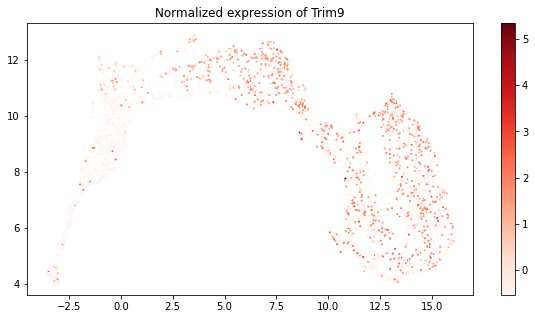

In [ ]:
model.plot_marker_gene('Trim9')